# Labeling

Next step is clustering since we are building a classifier but we don't have labels yet. The goal is to cluster our dataset and then evaluate some representants of their clusters and assign the whole cluster a label.

## Outliers

As first attempts of clustering showed, outliers in our dataset affect our basic clustering methods. So in the beginning of labeling process we try to filter those outliers out. Using search over contamination parameter where score is computed as mean of standard deviations of clusters' sizes using Agglomerative and KMeans algorithms (as they are quite general), we want to find the most suitable settings of outliers detection.

We compute filtered dataset size to standard deviation ratios and find the maximum value since that's probably the best trade-off between dataset reduction (we don't want to filter half of our dataset out) and outliers' affection of clustering methods (since they don't make clusters where there are just few members in).

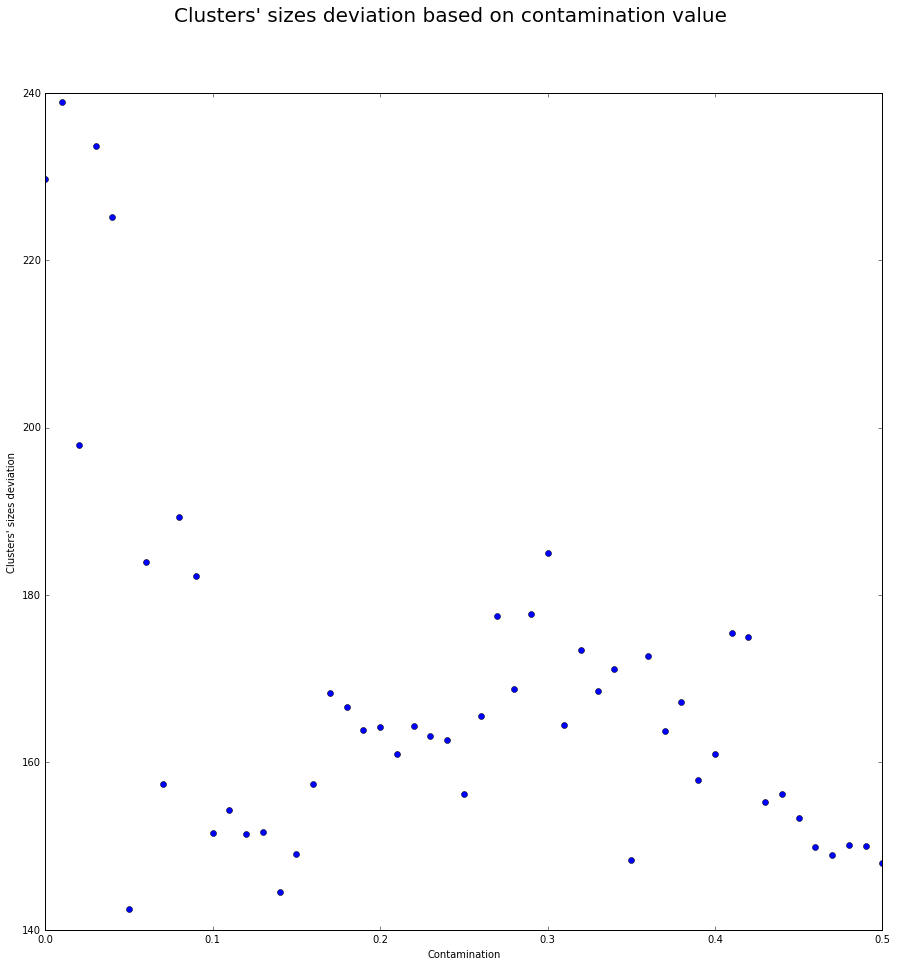

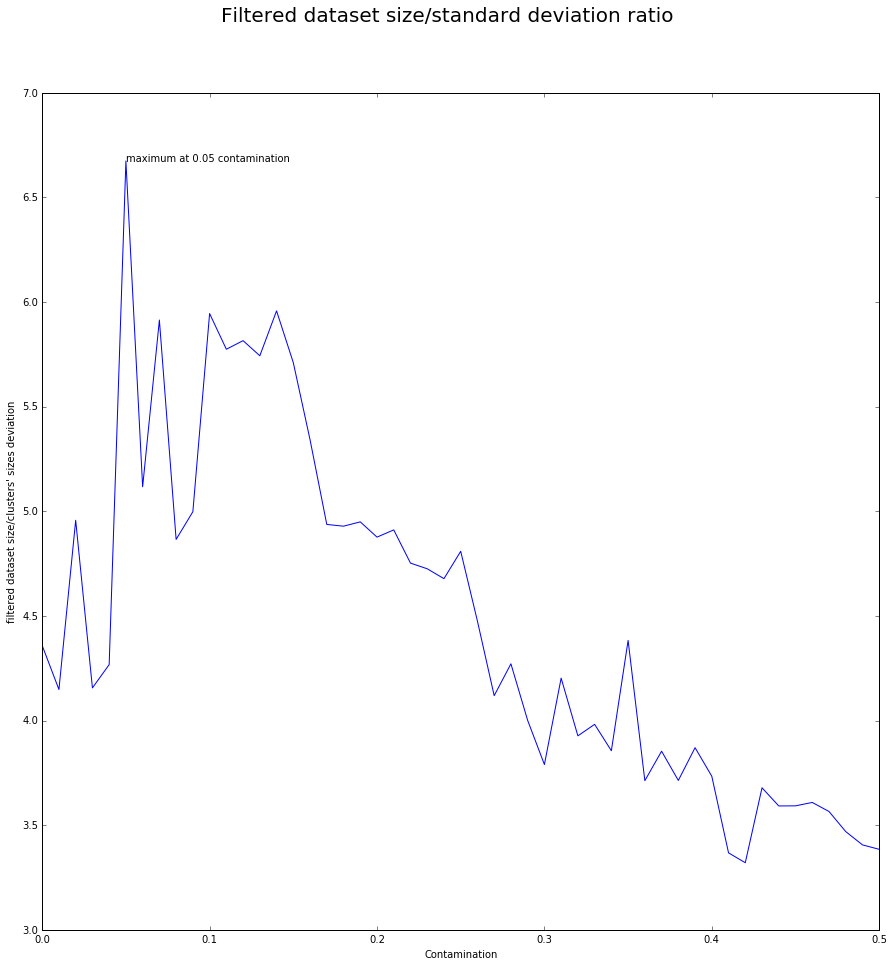

In [1]:
# outliers removal

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.manifold import MDS
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import AgglomerativeClustering, KMeans

data = pd.read_csv('../data/sample-manually-scaled.csv')
X = scale(data.values[:,1:].astype(float))

# tranform using manifold learning, otherwise the matrix is singular
# and elliptic envelope will fail to fit (TODO: find out why)
mds = MDS(n_components=12, metric=True, dissimilarity='euclidean', random_state=3)
X_mds = mds.fit_transform(X)

conts = []
stds = []
ratios = []

for contamination in np.arange(0, 0.51, 0.01):
    envelope = EllipticEnvelope(contamination=contamination)
    # detect ouliers
    outliers = envelope.fit(X_mds).predict(X_mds)
    
    # remove outliers from dataset
    filtered = data.select(lambda idx: outliers[idx] > 0)
    X = scale(filtered.values[:,1:].astype(float))
    
    # perform agglomerative clustering on filtered dataset
    clstr = AgglomerativeClustering(n_clusters=5)
    labels = clstr.fit_predict(X)
    _, counts = np.unique(labels, return_counts=True)
    
    # compute standard deviation of clusters' sizes
    agglo_std = np.std(counts)
    
    # perform kmeans clustering
    clstr = KMeans(n_clusters=5)
    labels = clstr.fit_predict(X)
    _, counts = np.unique(labels, return_counts=True)
    
    # compute standard deviation of clusters' sizes
    kmeans_std = np.std(counts)
    
    # compute mean of standard deviations
    std = np.mean([agglo_std, kmeans_std])
    
    # add values to plot data
    conts.append(contamination)
    stds.append(std)
    ratios.append(sum(counts) / std)

# plot results
fig = plt.figure(figsize=(15, 15), facecolor='white')
fig.suptitle('Clusters\' sizes deviation based on contamination value', size=20)
plt.plot(conts, stds, 'bo')
plt.xlabel('Contamination')
plt.ylabel('Clusters\' sizes deviation')

fig = plt.figure(figsize=(15, 15), facecolor='white')
ax = fig.add_subplot(111)
fig.suptitle('Filtered dataset size/standard deviation ratio', size=20)
plt.plot(conts, ratios)
plt.xlabel('Contamination')
plt.ylabel('filtered dataset size/clusters\' sizes deviation')

max_ratio = max(ratios)
idx = ratios.index(max_ratio)
ax.annotate('maximum at {0} contamination'.format(conts[idx]), xy=(conts[idx], ratios[idx]))

# pass resulted settings into elliptic envelope
envelope = EllipticEnvelope(contamination=conts[idx])
# detect ouliers
outliers = envelope.fit(X_mds).predict(X_mds)

# remove outliers from dataset
filtered = data.select(lambda idx: outliers[idx] > 0)

filtered.to_csv('../data/sample-filtered.csv', index=False)

plt.show()

## Clustering

Unfortunately, method cluster-then-label completely failed, but that could be expected. There are no obvious clusters so defining the boundaries is just guessing, moreover there are probably many readmes that very differ from our labeled dataset so they affect clustering a lot. Results of some cluster-then-label methods with default settings can be seen below.

"Ensemble" approach doesn't help us neither. If we measure just the accuracy of test samples where at least two out of three clusterings agree we get just a little bit better results.

In [2]:
# cluster-then-label method of label assignment

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import accuracy_score
from scipy.stats import mode

# load data
sample = pd.read_csv('../data/sample-filtered.csv')
X_smpl = sample.values[:,1:].astype(float)

classified = pd.read_csv('../data/classified-manually-scaled.csv')
X_tst = classified.values[:,1:-1].astype(float)
y_tst = classified.values[:,-1].astype(int)

X_cnct = np.concatenate((X_tst, X_smpl))

# initialize scalers
std_scaler = StandardScaler().fit(X_cnct)
mm_scaler = MinMaxScaler().fit(X_cnct)

N = 5

total = 0
for _ in range(N):
    # find clusters using KMeans
    clstr = KMeans(n_clusters=5)
    clstr.fit(std_scaler.transform(X_cnct))

    clusters = clstr.predict(std_scaler.transform(X_tst))

    # reassign cluster numbers to fit with original labeling
    labels = np.zeros_like(clusters)
    for i in range(5):
        mask = (clusters == i)
        labels[mask] = mode(y_tst[mask])[0]
        
    total += accuracy_score(y_tst, labels)
    
# compute accuracy
print('KMeans: {:.2%}'.format(total / N))

total = 0
for _ in range(N):
    # find clusters using Spectral clustering
    clstr = SpectralClustering(n_clusters=5)
    clusters = clstr.fit_predict(mm_scaler.transform(X_cnct))

    clusters = clusters[:len(y_tst)]

    # reassign cluster numbers to fit with original labeling
    labels = np.zeros_like(clusters)
    for i in range(5):
        mask = (clusters == i)
        labels[mask] = mode(y_tst[mask])[0]
        
    total += accuracy_score(y_tst, labels)

# compute accuracy
print('Spectral clustering: {:.2%}'.format(total / N))

total = 0
for _ in range(N):
    # find clusters using Agglomerative clustering
    clstr = AgglomerativeClustering(n_clusters=5)
    clusters = clstr.fit_predict(mm_scaler.transform(X_cnct))

    clusters = clusters[:len(y_tst)]

    # reassign cluster numbers to fit with original labeling
    labels = np.zeros_like(clusters)
    for i in range(5):
        mask = (clusters == i)
        labels[mask] = mode(y_tst[mask])[0]
        
    total += accuracy_score(y_tst, labels)

# compute accuracy
print('Agglomerative clustering: {:.2%}'.format(total / N))

KMeans: 46.52%
Spectral clustering: 46.96%
Agglomerative clustering: 39.13%


In [3]:
# ensemble cluster-then-label method of label assignment

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import accuracy_score
from scipy.stats import mode

def confidence(*args):
    output = []
    for row in zip(*args):
        size = len(row)        
        unique, counts = np.unique(row, return_counts=True)
        maxidx = np.argmax(counts)
        output.append(np.array([counts[maxidx] / size, unique[maxidx]]))
    return np.array(output)

# load data
sample = pd.read_csv('../data/sample-filtered.csv')
X_smpl = sample.values[:,1:].astype(float)

classified = pd.read_csv('../data/classified-manually-scaled.csv')
X_tst = classified.values[:,1:-1].astype(float)
y_tst = classified.values[:,-1].astype(int)

X_cnct = np.concatenate((X_tst, X_smpl))

# initialize scalers
std_scaler = StandardScaler().fit(X_cnct)
mm_scaler = MinMaxScaler().fit(X_cnct)

N = 5

total = 0
for _ in range(N):
    # find clusters using KMeans
    clstr = KMeans(n_clusters=5)
    clstr.fit(std_scaler.transform(X_cnct))

    clusters = clstr.predict(std_scaler.transform(X_tst))

    # reassign cluster numbers to fit with original labeling
    labels = np.zeros_like(clusters)
    for i in range(5):
        mask = (clusters == i)
        labels[mask] = mode(y_tst[mask])[0]

    # save predicted values
    y_kmeans = labels

    # find clusters using Spectral clustering
    clstr = SpectralClustering(n_clusters=5)
    clusters = clstr.fit_predict(mm_scaler.transform(X_cnct))

    clusters = clusters[:len(y_tst)]

    # reassign cluster numbers to fit with original labeling
    labels = np.zeros_like(clusters)
    for i in range(5):
        mask = (clusters == i)
        labels[mask] = mode(y_tst[mask])[0]

    # save predicted values
    y_spectral = labels

    # find clusters using Agglomerative clustering
    clstr = AgglomerativeClustering(n_clusters=5)
    clusters = clstr.fit_predict(mm_scaler.transform(X_cnct))
    
    clusters = clusters[:len(y_tst)]

    # reassign cluster numbers to fit with original labeling
    labels = np.zeros_like(clusters)
    for i in range(5):
        mask = (clusters == i)
        labels[mask] = mode(y_tst[mask])[0]

    # save predicted values
    y_agglo = labels

    cnf = confidence(y_kmeans, y_spectral, y_agglo)
    confident = (cnf[:,0] > 0.5)
    y_cnfdnt = y_tst[confident]
    labels = labels[confident]
    
    total += accuracy_score(y_cnfdnt, labels)
    
# compute accuracy
print('Ensemble: {:.2%}'.format(total / N))

Ensemble: 47.98%


## Semi-supervised learning

### Label propagation/spreading

So we try to use semi-supervised algorithms from `scikit-learn`. These work on graph-based approach. First, we assign labels to our sample dataset using these methods and then train Random forest classifier (used just as a baseline for our labeling methods) and using classification measure the "accuracy".

In [4]:
# label propagation/spreading

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.ensemble import RandomForestClassifier

#load data
sample = pd.read_csv('../data/sample-filtered.csv')
X_smpl = sample.values[:,1:].astype(float)
y_smpl = np.empty(len(X_smpl))
y_smpl.fill(-1)

classified = pd.read_csv('../data/classified-manually-scaled.csv')
X_tst = classified.values[:,1:-1].astype(float)
y_tst = classified.values[:,-1].astype(int)

X_cnct = np.concatenate((X_tst, X_smpl))
y_cnct = np.concatenate((y_tst, y_smpl))

# initialize scalers
std_scaler = StandardScaler().fit(X_cnct)
mm_scaler = MinMaxScaler().fit(X_cnct)

X_cnct = std_scaler.transform(X_cnct)
X_tst = std_scaler.transform(X_tst)

# initialize classifier
clf = RandomForestClassifier()

# label propagation (rbf)
lbl = LabelPropagation(kernel='rbf')
lbl.fit(X_cnct, y_cnct)
y_lbl = lbl.predict(X_cnct)

# classify
clf.fit(X_cnct, y_lbl)
y_clf = clf.predict(X_tst)

# compute accuracy
print('Label propagation (rbf): {:.2%}'.format(accuracy_score(y_tst, y_clf)))

# label propagation (knn)
lbl = LabelPropagation(kernel='knn')
lbl.fit(X_cnct, y_cnct)
y_lbl = lbl.predict(X_cnct)

# classify
clf.fit(X_cnct, y_lbl)
y_clf = clf.predict(X_tst)

# compute accuracy
print('Label propagation (knn): {:.2%}'.format(accuracy_score(y_tst, y_clf)))

# label spreading (rbf)
lbl = LabelSpreading(kernel='rbf')
lbl.fit(X_cnct, y_cnct)
y_lbl = lbl.predict(X_cnct)

# classify
clf.fit(X_cnct, y_lbl)
y_clf = clf.predict(X_tst)

# compute accuracy
print('Label spreading (rbf): {:.2%}'.format(accuracy_score(y_tst, y_clf)))

# label spreading (knn)
lbl = LabelSpreading(kernel='knn')
lbl.fit(X_cnct, y_cnct)
y_lbl = lbl.predict(X_cnct)

# classify
clf.fit(X_cnct, y_lbl)
y_clf = clf.predict(X_tst)

# compute accuracy
print('Label spreading (knn): {:.2%}'.format(accuracy_score(y_tst, y_clf)))

Label propagation (rbf): 19.57%
Label propagation (knn): 28.26%
Label spreading (rbf): 19.57%
Label spreading (knn): 78.26%


### Class balancing

As we see below, class balancing can help (actually, sometimes it helps and sometimes it doesn't). So in out pipeline we can try it and see if it gives us better accuracy.

In [5]:
# class balancing

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.ensemble import RandomForestClassifier

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import ClusterCentroids, InstanceHardnessThreshold, NearMiss

#load data
sample = pd.read_csv('../data/sample-filtered.csv')
X_smpl = sample.values[:,1:].astype(float)
y_smpl = np.empty(len(X_smpl))
y_smpl.fill(-1)

classified = pd.read_csv('../data/classified-manually-scaled.csv')
X_tst = classified.values[:,1:-1].astype(float)
y_tst = classified.values[:,-1].astype(int)

X_cnct = np.concatenate((X_tst, X_smpl))
y_cnct = np.concatenate((y_tst, y_smpl))

# initialize scaler
std_scaler = StandardScaler().fit(X_cnct)

X_cnct = std_scaler.transform(X_cnct)
X_tst = std_scaler.transform(X_tst)

# initialize classifier
clf = RandomForestClassifier()

# label spreading (knn)
lbl = LabelSpreading(kernel='knn')
lbl.fit(X_cnct, y_cnct)
y_lbl = lbl.predict(X_cnct)

# smote+enn (regular|all)
cb = SMOTEENN(kind_smote='regular', kind_enn='all')

# resample data multiple times to make equal-sized classes
X_cb, y_cb = cb.fit_sample(X_cnct, y_lbl)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)

_, counts = np.unique(y_cb, return_counts=True)
assert(all(counts == counts[0]), 'Classes are not equally sized')

# classify
clf.fit(X_cb, y_cb)
y_clf = clf.predict(X_tst)

# compute accuracy
print('Smote + ENN (regular|all): {:.2%}'.format(accuracy_score(y_tst, y_clf)))

# smote+enn (svm|all)
cb = SMOTEENN(kind_smote='svm', kind_enn='all')

# resample data multiple times to make equal-sized classes
X_cb, y_cb = cb.fit_sample(X_cnct, y_lbl)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)

_, counts = np.unique(y_cb, return_counts=True)
assert(all(counts == counts[0]), 'Classes are not equally sized')

# classify
clf.fit(X_cb, y_cb)
y_clf = clf.predict(X_tst)

# compute accuracy
print('Smote + ENN (svm|all): {:.2%}'.format(accuracy_score(y_tst, y_clf)))

# smote+enn (regular|mode)
cb = SMOTEENN(kind_smote='regular', kind_enn='mode')

# resample data multiple times to make equal-sized classes
X_cb, y_cb = cb.fit_sample(X_cnct, y_lbl)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)

_, counts = np.unique(y_cb, return_counts=True)
assert(all(counts == counts[0]), 'Classes are not equally sized')

# classify
clf.fit(X_cb, y_cb)
y_clf = clf.predict(X_tst)

# compute accuracy
print('Smote + ENN (regular|mode): {:.2%}'.format(accuracy_score(y_tst, y_clf)))

# smote+enn (svm|mode)
cb = SMOTEENN(kind_smote='svm', kind_enn='mode')

# resample data multiple times to make equal-sized classes
X_cb, y_cb = cb.fit_sample(X_cnct, y_lbl)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)
X_cb, y_cb = cb.fit_sample(X_cb, y_cb)

_, counts = np.unique(y_cb, return_counts=True)
assert(all(counts == counts[0]), 'Classes are not equally sized')

# classify
clf.fit(X_cb, y_cb)
y_clf = clf.predict(X_tst)

# compute accuracy
print('Smote + ENN (svm|mode): {:.2%}'.format(accuracy_score(y_tst, y_clf)))

# cluster centroids
cb = ClusterCentroids()

# resample data
X_cb, y_cb = cb.fit_sample(X_cnct, y_lbl)

_, counts = np.unique(y_cb, return_counts=True)
assert(all(counts == counts[0]), 'Classes are not equally sized')

# classify
clf.fit(X_cb, y_cb)
y_clf = clf.predict(X_tst)

# compute accuracy
print('Cluster centroids: {:.2%}'.format(accuracy_score(y_tst, y_clf)))

# instance hardness treshold
cb = InstanceHardnessThreshold()

# resample data
X_cb, y_cb = cb.fit_sample(X_cnct, y_lbl)

_, counts = np.unique(y_cb, return_counts=True)
assert(all(counts == counts[0]), 'Classes are not equally sized')

# classify
clf.fit(X_cb, y_cb)
y_clf = clf.predict(X_tst)

# compute accuracy
print('Instance hardness treshold: {:.2%}'.format(accuracy_score(y_tst, y_clf)))

# near miss
cb = NearMiss()

# resample data
X_cb, y_cb = cb.fit_sample(X_cnct, y_lbl)

_, counts = np.unique(y_cb, return_counts=True)
assert(all(counts == counts[0]), 'Classes are not equally sized')

# classify
clf.fit(X_cb, y_cb)
y_clf = clf.predict(X_tst)

# compute accuracy
print('Near miss: {:.2%}'.format(accuracy_score(y_tst, y_clf)))

Smote + ENN (regular|all): 78.26%
Smote + ENN (svm|all): 73.91%
Smote + ENN (regular|mode): 80.43%
Smote + ENN (svm|mode): 80.43%
Cluster centroids: 67.39%
Instance hardness treshold: 41.30%
Near miss: 65.22%


### Classifiers comparison

Now, we can compare different classifiers with default settings and see which one is the best for our purpose. And the result is Random Forest, the one we used the whole time as the baseline. Also Gradient Boosting method gives almost as good results as Random Forest.

In [6]:
# classifier comparison

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#load data
sample = pd.read_csv('../data/sample-filtered.csv')
X_smpl = sample.values[:,1:].astype(float)
y_smpl = np.empty(len(X_smpl))
y_smpl.fill(-1)

classified = pd.read_csv('../data/classified-manually-scaled.csv')
X_tst = classified.values[:,1:-1].astype(float)
y_tst = classified.values[:,-1].astype(int)

X_cnct = np.concatenate((X_tst, X_smpl))
y_cnct = np.concatenate((y_tst, y_smpl))

# initialize scaler
std_scaler = StandardScaler().fit(X_cnct)

X_cnct = std_scaler.transform(X_cnct)
X_tst = std_scaler.transform(X_tst)

# label spreading (knn)
lbl = LabelSpreading(kernel='knn')
lbl.fit(X_cnct, y_cnct)
y_lbl = lbl.predict(X_cnct)

# initialize classifiers
forest = RandomForestClassifier()
lr = LogisticRegression()
sgd = SGDClassifier()
knn = KNeighborsClassifier()
aboost = AdaBoostClassifier()
gboost = GradientBoostingClassifier()

# perform classification and measure the accuracy for Random forest
forest.fit(X_cnct, y_lbl)
y_clf = forest.predict(X_tst)

print('Random forest: {:.2%}'.format(accuracy_score(y_tst, y_clf)))

# perform classification and measure the accuracy for Logistic regression
lr.fit(X_cnct, y_lbl)
y_clf = lr.predict(X_tst)

print('Logistic regression: {:.2%}'.format(accuracy_score(y_tst, y_clf)))

# perform classification and measure the accuracy for Stochastic gradient descent
sgd.fit(X_cnct, y_lbl)
y_clf = sgd.predict(X_tst)

print('Stochastic gradient descent: {:.2%}'.format(accuracy_score(y_tst, y_clf)))

# perform classification and measure the accuracy for K-nearest neighbors
knn.fit(X_cnct, y_lbl)
y_clf = knn.predict(X_tst)

print('K-nearest neighbors: {:.2%}'.format(accuracy_score(y_tst, y_clf)))

# perform classification and measure the accuracy for Ada boost
aboost.fit(X_cnct, y_lbl)
y_clf = aboost.predict(X_tst)

print('Ada boost: {:.2%}'.format(accuracy_score(y_tst, y_clf)))

# perform classification and measure the accuracy for Gradient boosting
gboost.fit(X_cnct, y_lbl)
y_clf = gboost.predict(X_tst)

print('Gradient boosting: {:.2%}'.format(accuracy_score(y_tst, y_clf)))

Random forest: 78.26%
Logistic regression: 65.22%
Stochastic gradient descent: 50.00%
K-nearest neighbors: 73.91%
Ada boost: 65.22%
Gradient boosting: 78.26%


### Weighing of samples to get better results

At the end of labeling process, we try to set samples' weights to get even better accuracy on our testing data. To find the best weighing we use evolutionary strategy algorithm (well, at least something like that). The results are that custom weighing can give better result but it's almost coincidence which one and evolutionary strategy does not give us a growing trend.

Highest accuracy: 0.8260869565217391


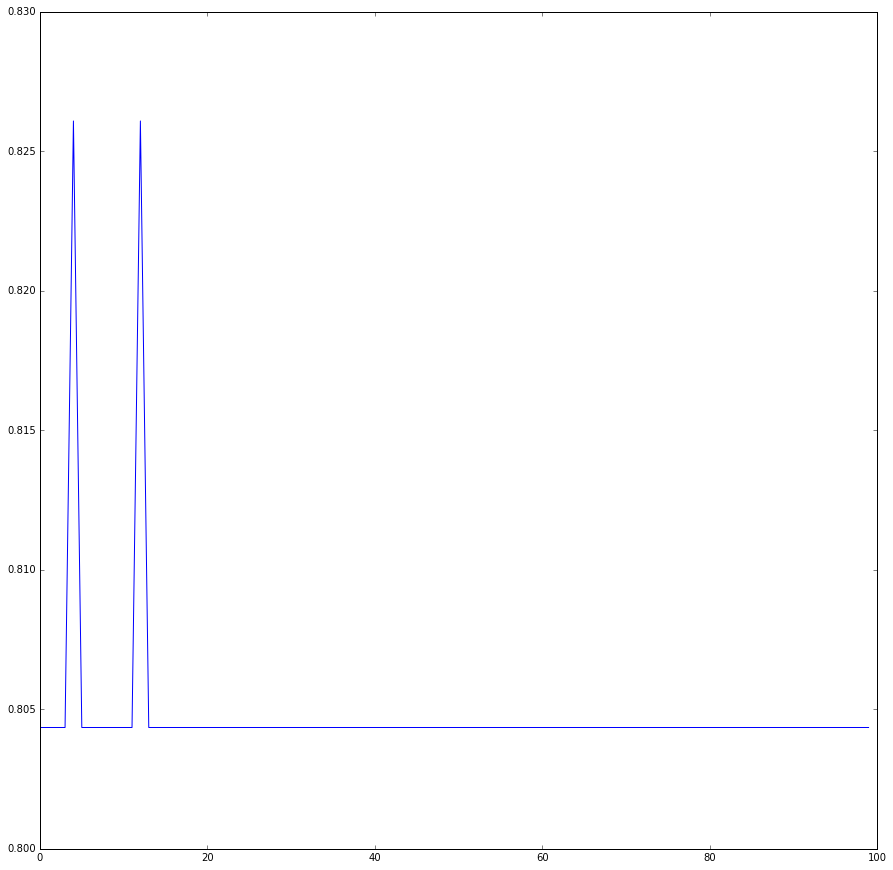

In [7]:
%matplotlib inline
import random
import math

from collections import deque

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import LabelSpreading

from sklearn.ensemble import RandomForestClassifier
    
# === EVOLUTIONARY STRATEGY ALGORITHM PROTOTYPE ===
# TODO: explore more formal methods in evolutionary strategy (chromosomes as real vectors)
def limited_collection(K):
    data = deque()
    def collection(value=None):
        if value != None:
            if len(data) == K:
                data.popleft()
            data.append(value)
        return list(data)
    
    return collection

def two_point_crossover(factory, father, mother):
    k = np.random.randint(0, len(father))
    l = np.random.randint(0, len(father))
    
    if k == l:
        k -= round(k / 2)
        l += round(l / 2)
    elif k > l:
        l, k = k, l
        
    son = factory()
    daughter = factory()
    
    son[:k] = father[:k]
    son[k:l] = mother[k:l]
    son[l:] = father[l:]
    
    daughter[:k] = mother[:k]
    daughter[k:l] = father[k:l]
    daughter[l:] = mother[l:]
    
    return son, daughter
    
def init_opposite_mutatation(K):
    def opposite_mutatation(factory, parent):
        child = factory()
        
        for i in range(len(parent)):
            opposite = np.random.sample() < 0.5
            if opposite:
                child[i] = K - parent[i]
            else:
                child[i] = parent[i]
    
        return child
    
    return opposite_mutatation

def init_tournament_selection(K):
    def tournament_selection(population, fitness, i_generation):
        selected = []
        random.shuffle(population)
        
        for i in range(0, len(population), K):
            tournament = population[i:i + K]
            winner_idx = np.argmax(list(map(lambda ind: fitness(ind), tournament)))
            selected.append(population[winner_idx])
            
        return selected
    
    return tournament_selection

def init_rank_based_selection(get_size, compute_sp, rank_func):
    def rank_based_selection(population, fitnesses, i_generation):
        N = len(population)
        population = list(map(
                lambda ind: ind[0],
                sorted(zip(population, fitnesses),
                       key=lambda ind: ind[1])))
        
        selected = []
        
        n = min(max(get_size(N, i_generation), 2), N)
        sp = compute_sp(i_generation)
        
        for _ in range(n):
            wheel_result = random.uniform(0, 1) * N
            
            i = 0
            while wheel_result > rank_func(i, sp, N):
                wheel_result -= rank_func(i, sp, N)
                i += 1
            
            selected.append(population[i])
            
        return selected
        
    return rank_based_selection

def default_rank_based_selection():
    return init_rank_based_selection(
        lambda N, i: round(N * ((1 / (1 + 1.03 ** -i))) ** math.e),
        lambda i: ((1 / (1 + math.exp(-i))) ** math.e) + 1,
        lambda i, sp, N: 2 - sp + 2 * (sp - 1) * i / (N - 1)
    )

def evolution(factory, fitness,
              selection=default_rank_based_selection(),
              crossover=two_point_crossover,
              mutation=init_opposite_mutatation(1),
              stats=lambda population, i_gen: None):
    def run(population_size=100, max_iterations=100):
        population = [factory() for _ in range(population_size)]
        bests = limited_collection(10)
        
        local_optimum = ([], 0)
        for i_gen in range(max_iterations):
            fitnesses = list(map(lambda ind: fitness(ind), population))
            stats(population, fitnesses, i_gen)
            parents = selection(population, fitnesses, i_gen)
            next_generation = []
            
            n = len(parents)
            if n % 2 == 1:
                n -= 1
            
            for i_ind in range(0, n, 2):
                son, daughter = crossover(factory, parents[i_ind], parents[i_ind + 1])
                next_generation.append(son)
                next_generation.append(daughter)
                
                if len(next_generation) >= len(population):
                    break
                    
            while len(next_generation) < len(population):
                idx = random.randint(0, len(parents) - 1)
                next_generation.append(mutation(factory, parents[idx]))
                
            data = bests(max(fitnesses))
            
            if len(data) == 10:
                if max(data) == min(data):
                    split = round(population_size / 1.5)
                    next_generation = next_generation[:split]
                    while len(next_generation) != population_size:
                        next_generation.append(factory())
        
            max_idx = np.argmax(fitnesses)
            if fitnesses[max_idx] > local_optimum[1]:
                local_optimum = (population[max_idx], fitnesses[max_idx])
            population = next_generation
             
        fitnesses = list(map(lambda ind: fitness(ind), population))
        max_idx = np.argmax(fitnesses)
        
        if fitnesses[max_idx] > local_optimum[1]:
            return (population[max_idx], fitnesses[max_idx])
        else:
            return local_optimum
                    
    return run

#load data
sample = pd.read_csv('../data/sample-filtered.csv')
X_smpl = sample.values[:,1:].astype(float)
y_smpl = np.empty(len(X_smpl))
y_smpl.fill(-1)

classified = pd.read_csv('../data/classified-manually-scaled.csv')
X_tst = classified.values[:,1:-1].astype(float)
y_tst = classified.values[:,-1].astype(int)

X_cnct = np.concatenate((X_tst, X_smpl))
y_cnct = np.concatenate((y_tst, y_smpl))

# initialize scaler
std_scaler = StandardScaler().fit(X_cnct)

X_cnct = std_scaler.transform(X_cnct)
X_tst = std_scaler.transform(X_tst)

# label spreading (knn)
lbl = LabelSpreading(kernel='knn')
lbl.fit(X_cnct, y_cnct)
y_lbl = lbl.predict(X_cnct)

# initialize classifiers
forest = RandomForestClassifier()

def factory():
    return np.random.sample(len(X_cnct))

def fitness(individual):
    return accuracy_score(y_tst, forest.fit(X_cnct, y_lbl, individual).predict(X_tst))

x = []
y = []
def stats(population, fitnesses, i_gen):
    x.append(i_gen)
    y.append(max(fitnesses))

print('Highest accuracy: {}'.format(evolution(factory, fitness, stats=stats)(100, 100)[1]))

fig = plt.figure(figsize=(15, 15), facecolor='white')
plt.plot(x, y)

plt.show()